In [1]:
config_file = 'delineation/configs/dislocation_matching_disp_and_warp_and var_home.yml'
aug_config_file = 'delineation/configs/aug.yml'

In [2]:
import torch
from delineation.configs.defaults_segmentation import _C as cfg
from delineation.datasets import make_data_loader
%matplotlib inline
import matplotlib.pyplot as plt

import yaml

cfg.merge_from_file(config_file)
with open(aug_config_file, 'r') as ymlfile:
    cfg_aug = yaml.load(ymlfile)

In [3]:
train_loader, val_loader = make_data_loader(cfg, cfg_aug)

In [4]:
l, r, lgt, rgt, dlgt, l_name = train_loader.dataset[0]
print(l_name)

1109_1109 DPC DF4 71.0 kx DF4-B_LEFT.png


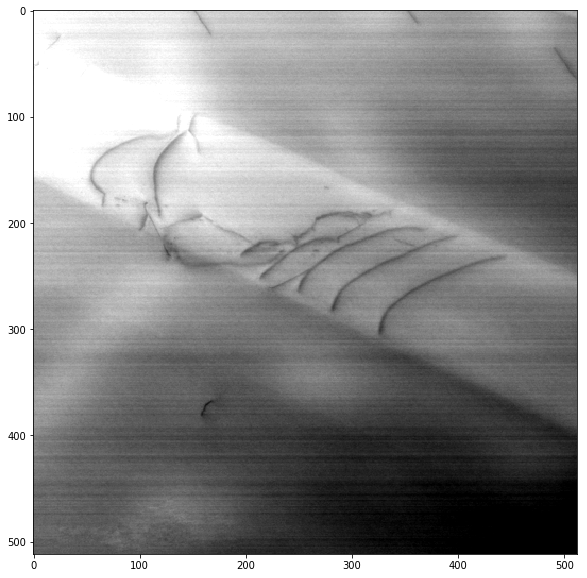

In [5]:
plt.figure(figsize = (10,10))
plt.imshow(l[0], cmap='gray')

0.0
6.0


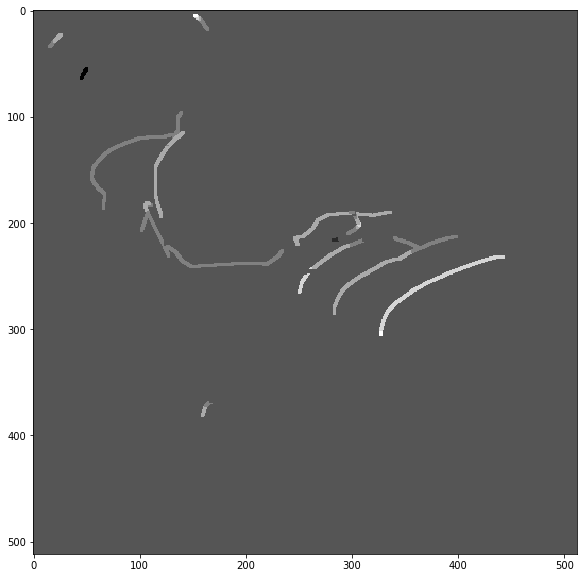

In [7]:
plt.figure(figsize = (10,10))

plt.imshow(dlgt, cmap='gray')
print(dlgt.min())
print(dlgt.max())

In [ ]:
import torch.nn.functional as F

def warp(image, disparity):
    ''' image : left_image (N, C, H, W)
        flow  : right disparity
        output : right image
        Requires CUDA available GPU'''

    # normalize flow-field vector
    H, W = image.size()[2], image.size()[3]
    disparity = disparity.permute(0,2,3,1)
    flow = torch.nn.ZeroPad2d((0,1,0,0))(disparity)
    flow = 2 * flow / W

    # create normalized meshgrid
    a = torch.linspace(-1.0, 1.0, H, dtype=torch.float32, requires_grad=False).cuda()
    b = torch.linspace(-1.0, 1.0, W, dtype=torch.float32, requires_grad=False).cuda()
    yy = a.view(-1,1).repeat(1, W)
    xx = b.repeat(H, 1)

    meshgrid = torch.cat([xx.unsqueeze_(2), yy.unsqueeze_(2)], 2).unsqueeze_(0)

    # add flow to meshgrid
    pixloc = meshgrid + flow

    # sample grid
    warped_image = F.grid_sample(image, pixloc)
    return warped_image

In [ ]:
warped_img = warp(rgt.unsqueeze(0).cuda(), torch.from_numpy(dlgt).unsqueeze(0).unsqueeze(0).cuda())

In [ ]:
plt.figure(figsize = (10,10))
plt.imshow(warped_img.cpu().squeeze()*lgt[0], cmap='gray')


In [ ]:
plt.figure(figsize = (10,10))

plt.imshow(lgt[0], cmap='gray')


In [ ]:
plt.figure(figsize = (10,10))
plt.imshow(rgt[0], cmap='gray')
